This is loosely based on https://smorabit.github.io/tutorials/8_velocyto/

In [43]:
import scvelo as scv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import os

In [2]:
loom_dir = 'RNA_velocity/'
data_dir = 'exported_matrices/'

datasets = pd.read_csv("datasets.csv", index_col=None)

output_dir = 'plots/RNA_velocity/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

In [3]:
def convert_to_AnnData(dataset: str, verbose: bool = True) -> anndata.AnnData:
    """ 
    Loads the velocity data for a given dataset.

    Parameters
    ----------
    dataset : str
        The dataset to load.
    verbose : bool
        Whether to print out progress information, defaults to True.

    Returns
    -------
    adata : anndata.AnnData
        The AnnData object containing the expression and velocity data.    
    """

    # Start by merging the loom files
    filtered_datasets = datasets[datasets['study_id'] == dataset]
    loom_filenames = [f"{row['study_id']}_{row['source']}" for _,
                      row in filtered_datasets.iterrows()]

    # Read dataset information
    metadata = pd.read_csv(f"{data_dir}{dataset}_metadata.csv", index_col=None)
    pca = pd.read_csv(f"{data_dir}/{dataset}_pca.csv", index_col=None)
    umap = pd.read_csv(f"{data_dir}/{dataset}_umap.csv", index_col=None)
    clusters = pd.read_csv(
        f"{data_dir}/{dataset}_clusters.csv", index_col=None)
    counts = pd.read_csv(
        f"{data_dir}{dataset}_counts.csv", index_col=0)
    gene_names = counts.index.values
    
    vel_data = None
    num_removed = 0

    for i, filename in enumerate(loom_filenames):
        if verbose:
            print(f"Loading {filename}.loom")
        if i == 0:
            vel_data = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data, id_length=16, alphabet="[ACGT]", inplace=True)
            vel_data.var_names_make_unique()

            # Only select common genes
            vel_data = vel_data[:, gene_names]
        else:
            vel_data2 = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data2, id_length=16, alphabet="[ACGT]", inplace=True)

            common_barcodes = np.intersect1d(
                vel_data.obs.index, vel_data2.obs.index)

            # Remove barcodes that are in both datasets from the second dataset, otherwise scv.utils.merge will fail
            # This is not perfect, but it's a very small number of barcodes
            vel_data2 = vel_data2[~vel_data2.obs.index.isin(common_barcodes)]
            num_removed += len(common_barcodes)

            vel_data2.var_names_make_unique()
            vel_data2 = vel_data2[:, gene_names]
            vel_data = vel_data.concatenate(vel_data2, index_unique=None)


    if verbose:
        print(f"Removed {num_removed} barcodes that were in multiple datasets")
        print(f"Final shape: {vel_data.shape}")

    # Add metadata and dimensionality reductions
    
    vel_barcodes = vel_data.obs.index
    vel_data.var.index = gene_names

    pca['Barcode'] = [x.split('-')[0] for x in pca['Barcode']]
    pca = pca.drop_duplicates(subset=['Barcode'])
    pca = pca[pca['Barcode'].isin(vel_barcodes)]
    pca = pca.set_index('Barcode', drop=True)
    pca = pca.reindex(vel_barcodes)

    umap['Barcode'] = [x.split('-')[0] for x in umap['Barcode']]
    umap = umap.drop_duplicates(subset=['Barcode'])
    umap = umap[umap['Barcode'].isin(vel_barcodes)]
    umap = umap.set_index('Barcode', drop=True)
    umap = umap.reindex(vel_barcodes)

    clusters['Barcode'] = [x.split('-')[0] for x in clusters['Barcode']]
    clusters = clusters.drop_duplicates(subset=['Barcode'])
    clusters = clusters[clusters['Barcode'].isin(vel_barcodes)]
    clusters = clusters.set_index('Barcode', drop=True)
    clusters = clusters.reindex(vel_barcodes)

    vel_data.obsm['X_pca'] = pca
    vel_data.obsm['X_umap'] = np.vstack(
        (umap['UMAP_1'].values, umap['UMAP_2'].values)).T
    vel_data.obs["cluster"] = [f"C{c}" for c in clusters['Cluster']]
    vel_data.obs["cluster"] = vel_data.obs["cluster"].astype("category")
    vel_data.obs["community_marker"] = [f"C_{int(c)}" if not np.isnan(c) else "n/a" for c in clusters['Community_markers_10']]
    vel_data.obs["community_marker"] = vel_data.obs["community_marker"].astype("category")

    return vel_data

In [10]:
adata = process_velocity('Cheung2018M')
adata = convert_to_AnnData(adata)
scv.tl.rank_velocity_genes(adata, groupby="community_marker", min_corr=0.4)
scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
scv.plt.velocity(adata, "Nedd4")

Processing Cheung2018M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/898 [00:00<?, ?gene/s]

    finished (0:00:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/961 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


NotImplementedError: Equality comparisons are not supported for AnnData objects, instead compare the desired attributes.

We perform velocity calculation for all datasets and put the results in the `vel_objects` dictionary so we can plot things later faster.

In [4]:
def process_velocity(dataset:str) -> anndata.AnnData:
    print(f"Processing {dataset}")
    adata = convert_to_AnnData(dataset, verbose=False)
    scv.pp.filter_and_normalize(adata, enforce=True)
    scv.pp.moments(adata)
    scv.tl.recover_dynamics(adata, n_jobs=16)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)
    scv.tl.rank_velocity_genes(adata, groupby="community_marker", min_corr=0.4)
    
    return adata

vel_objects = {}

for dataset in [d for d in datasets['study_id'].unique() if d not in ['Ho2020M', 'Ho2020F']]:
    vel_objects[dataset] = process_velocity(dataset)

Processing Ruf_Zamojski2021F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors


2024-09-11 10:25:47.347548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 10:25:51.335125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/940 [00:00<?, ?gene/s]

    finished (0:00:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1584 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Ruf_Zamojski2021M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/1239 [00:00<?, ?gene/s]

    finished (0:00:14) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1360 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Lopez2021M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/1157 [00:00<?, ?gene/s]

    finished (0:00:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/354 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Allensworth2021F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/547 [00:00<?, ?gene/s]

    finished (0:00:06) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/313 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Vennekens2021M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/1069 [00:00<?, ?gene/s]

    finished (0:00:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/541 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Mayran2019M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/1122 [00:00<?, ?gene/s]

    finished (0:00:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/954 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Cheung2018M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/898 [00:00<?, ?gene/s]

    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/961 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Kucka2021F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/105 [00:00<?, ?gene/s]

    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1228 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Fletcher2019F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/39 [00:00<?, ?gene/s]

    finished (0:00:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/391 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
Processing Fletcher2019M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/45 [00:00<?, ?gene/s]

    finished (0:00:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/548 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Transitions for communmities calculated with markers 

saving figure to file plots/RNA_velocity/Ruf_Zamojski2021F_velocity_umap_stream.png


saving figure to file plots/RNA_velocity/Ruf_Zamojski2021F_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


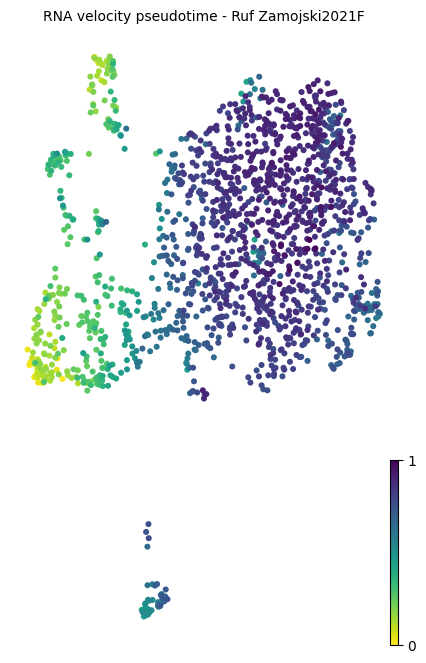

saving figure to file plots/RNA_velocity/Ruf_Zamojski2021M_velocity_umap_stream.png


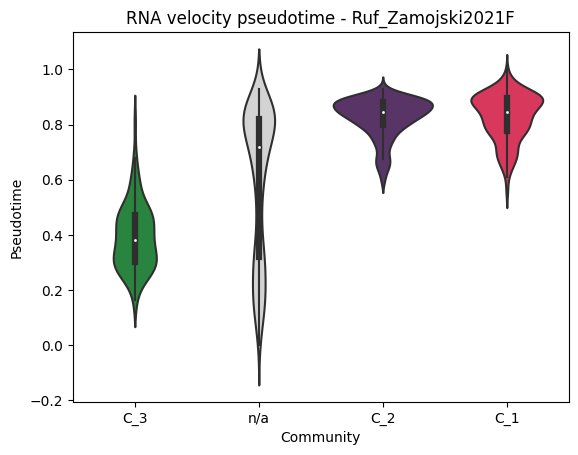

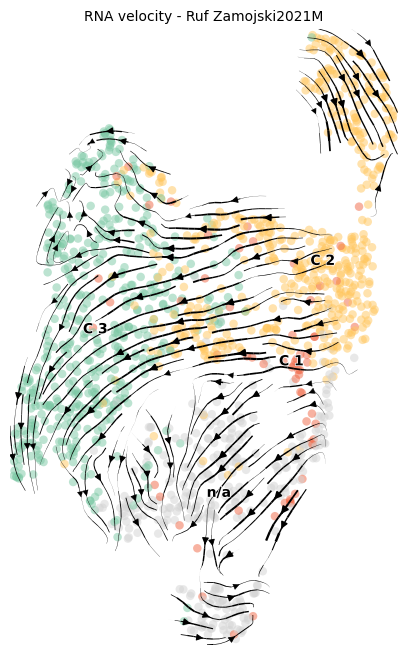

saving figure to file plots/RNA_velocity/Ruf_Zamojski2021M_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


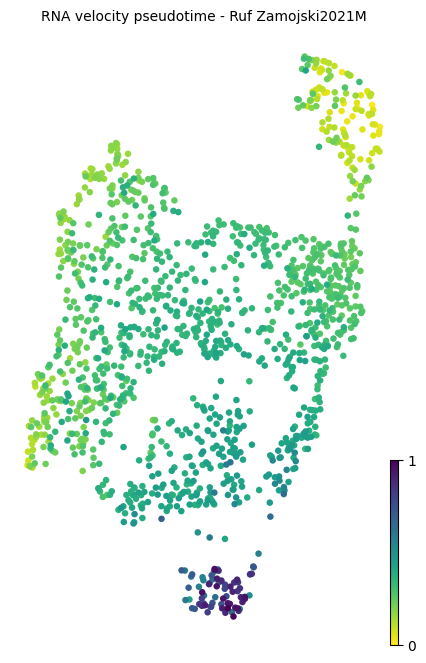

saving figure to file plots/RNA_velocity/Lopez2021M_velocity_umap_stream.png


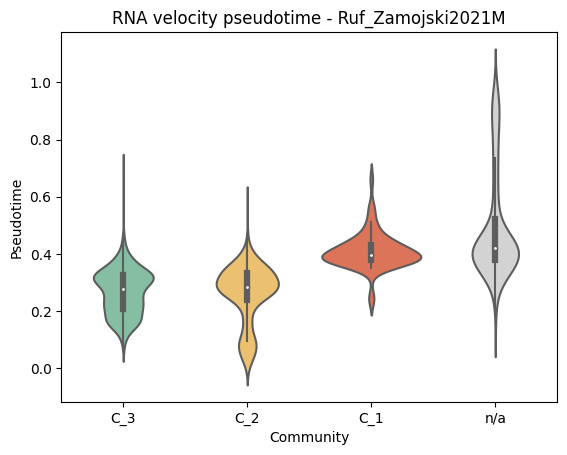

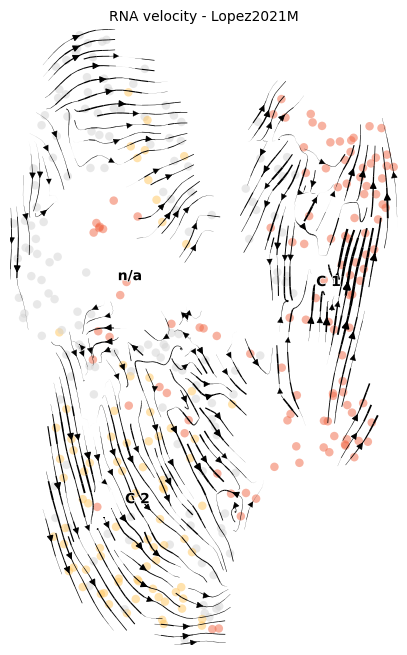

saving figure to file plots/RNA_velocity/Lopez2021M_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


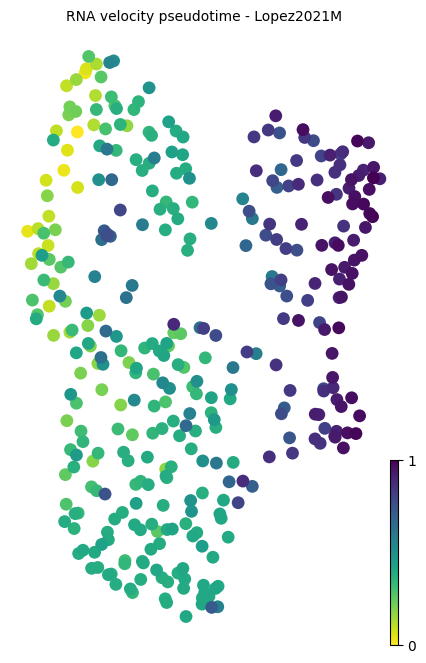

saving figure to file plots/RNA_velocity/Allensworth2021F_velocity_umap_stream.png


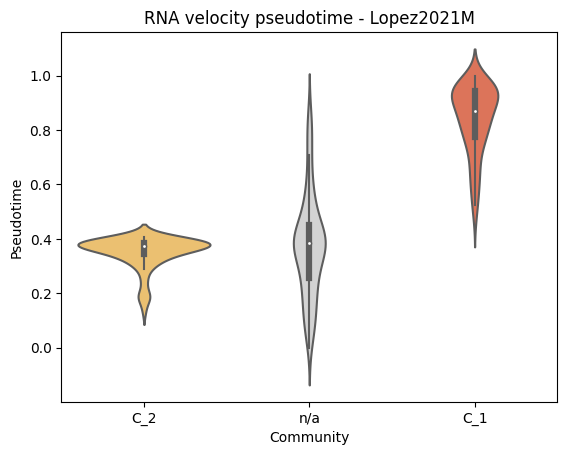

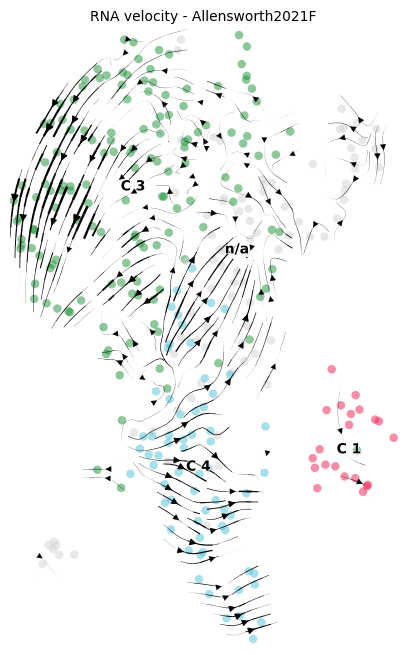

saving figure to file plots/RNA_velocity/Allensworth2021F_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


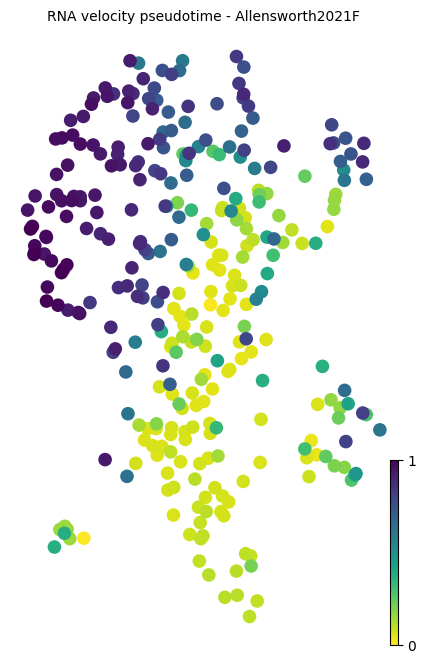

saving figure to file plots/RNA_velocity/Vennekens2021M_velocity_umap_stream.png


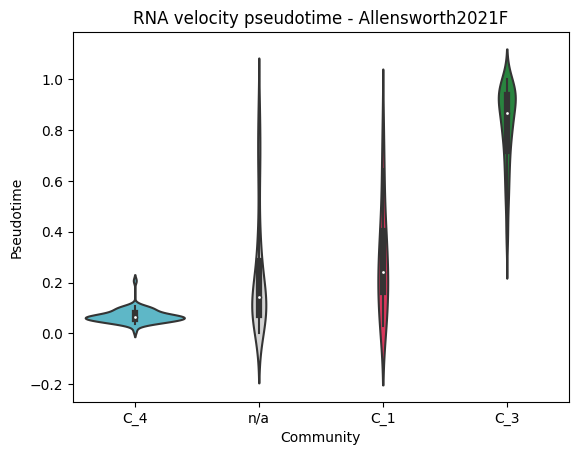

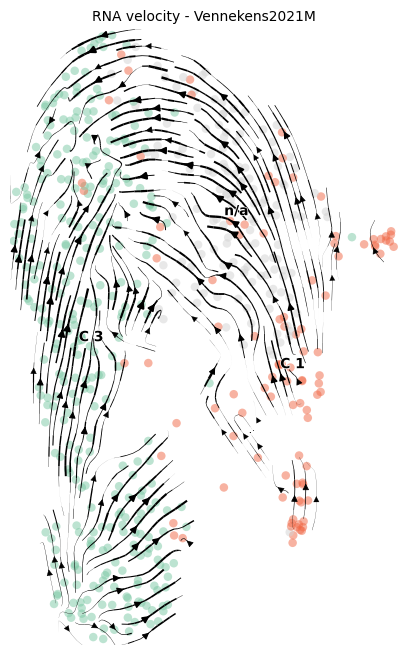

saving figure to file plots/RNA_velocity/Vennekens2021M_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


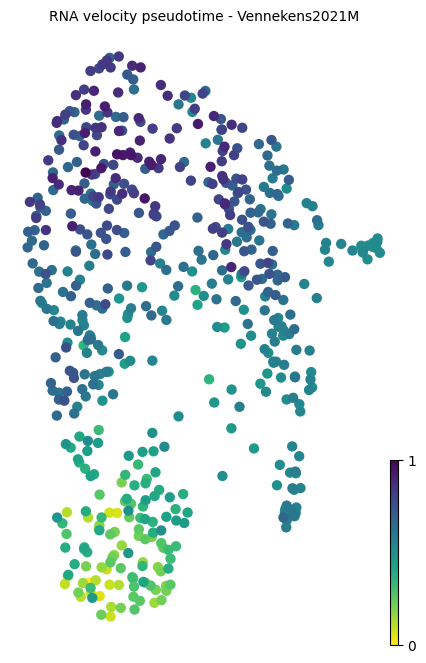

saving figure to file plots/RNA_velocity/Mayran2019M_velocity_umap_stream.png


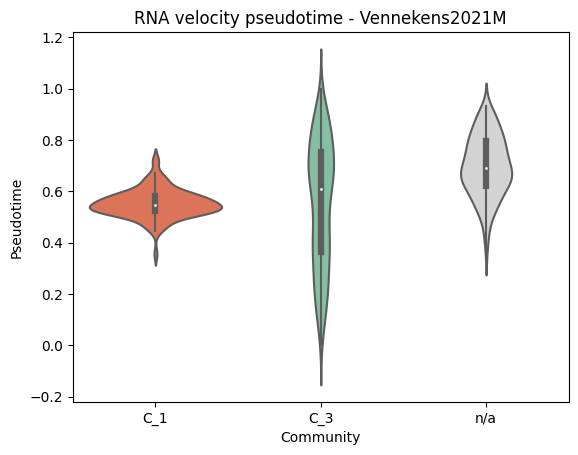

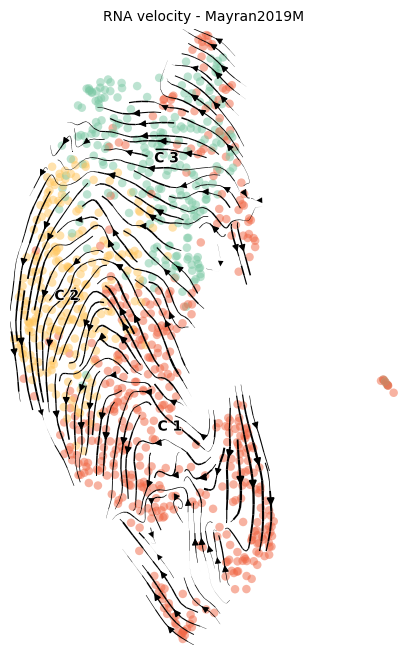

saving figure to file plots/RNA_velocity/Mayran2019M_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


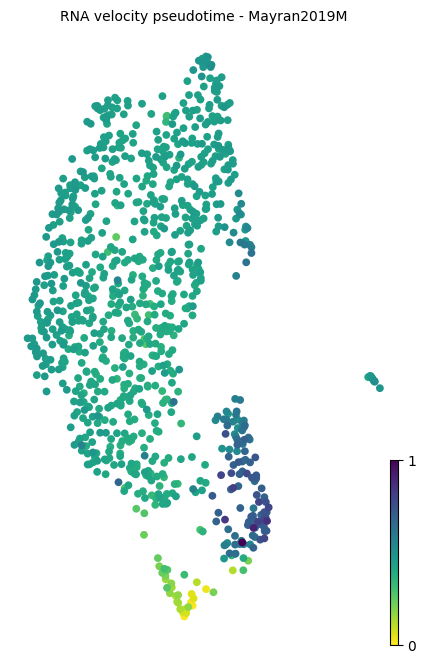

saving figure to file plots/RNA_velocity/Cheung2018M_velocity_umap_stream.png


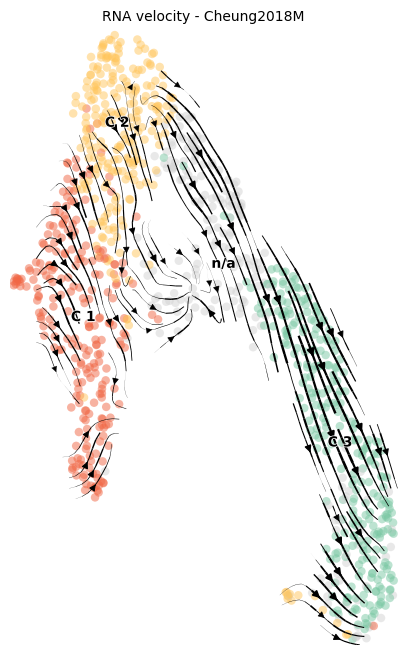

saving figure to file plots/RNA_velocity/Cheung2018M_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


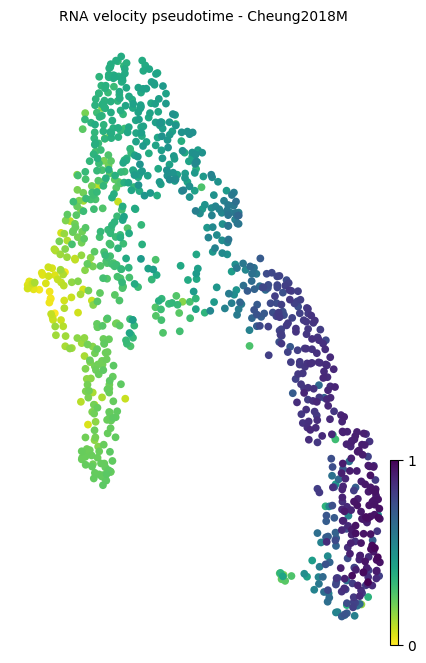

saving figure to file plots/RNA_velocity/Kucka2021F_velocity_umap_stream.png


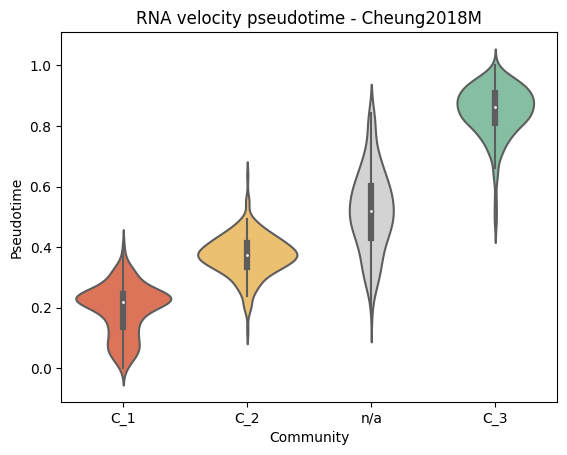

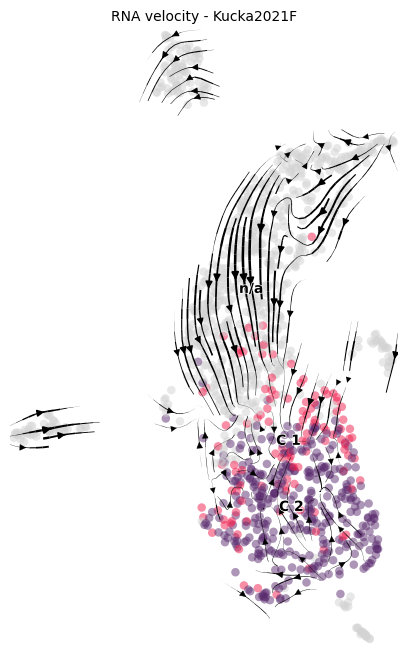

saving figure to file plots/RNA_velocity/Kucka2021F_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file plots/RNA_velocity/Fletcher2019F_velocity_umap_stream.png


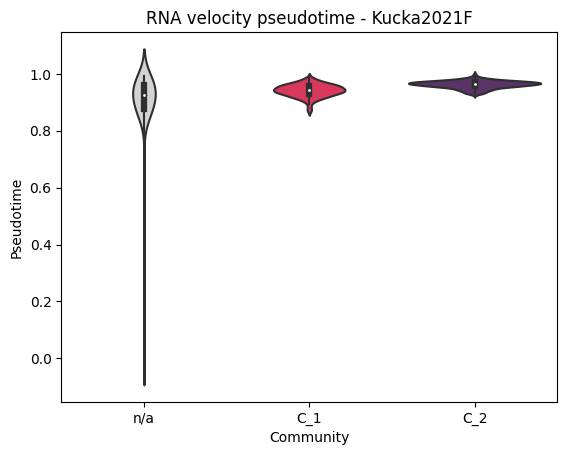

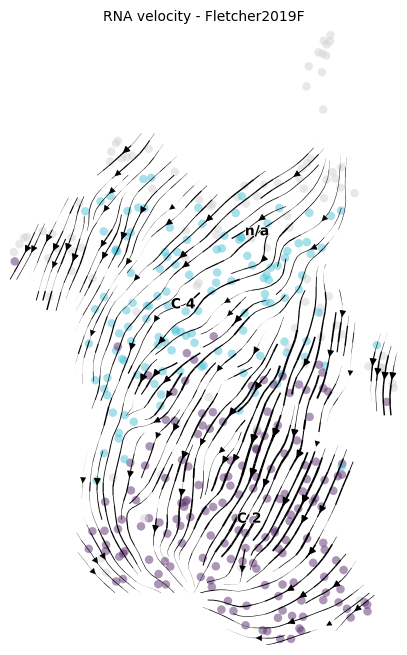

saving figure to file plots/RNA_velocity/Fletcher2019F_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


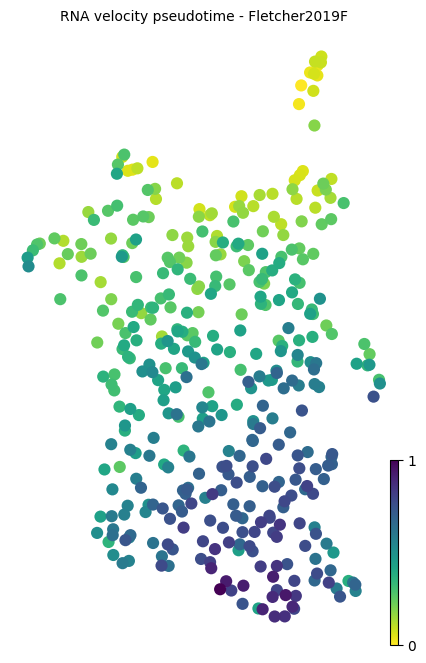

saving figure to file plots/RNA_velocity/Fletcher2019M_velocity_umap_stream.png


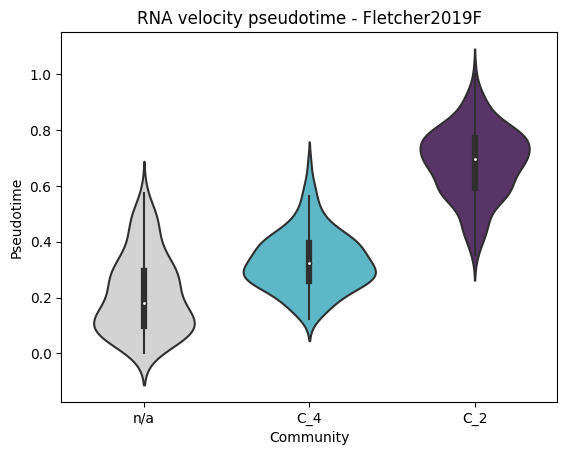

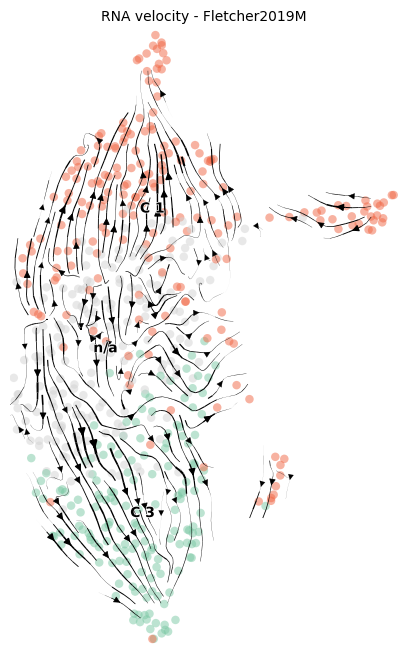

saving figure to file plots/RNA_velocity/Fletcher2019M_velocity_umap_pseudotime.png


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


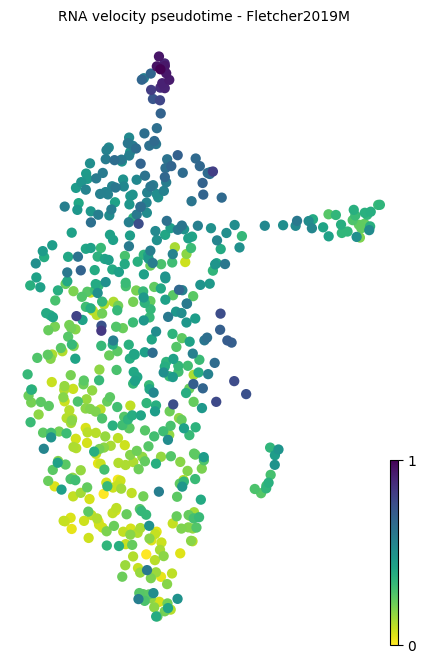

In [62]:
def do_velocity_plot(dataset: str, type: str = "stream", save: bool = True):
    """
    Plots the RNA velocity for a given dataset.

    Parameters
    ----------
    dataset : str
        The dataset to plot.
    type : str
        The type of plot to generate, one of "stream" (default, stream plot) or "pseudotime" (pseudotime plotted on UMAP) or "pseudotime_vln" (summary violin plot of pseudotime)
    """
    assert (type in ["stream", "pseudotime", "pseudotime_vln"])

    adata = vel_objects[dataset]

    # We want the palette to match what we got from R
    communities = list(adata.obs['community_marker'].cat.categories)
    if dataset.endswith("M"):
        community_palette = {"C_1": "#F16745",
                             "C_2": "#FFC65D", "C_3": "#7BC8A4", "n/a": "#D3D3D3"}
    elif dataset.endswith("F"):
        community_palette = {"C_1": "#F11E4E", "C_2": "#5B2C6F",
                             "C_3": "#1A9337", "C_4": "#4CC3D9", "n/a": "#D3D3D3"}
    if type == "stream":
        if save:
            outfile = f"{output_dir}{dataset}_velocity_umap_{type}.png"
        else:
            outfile = None

        fig, ax = plt.subplots(figsize=(5, 8))

        scv.pl.velocity_embedding_stream(adata, basis='umap', color=['community_marker'],
                                         palette=[community_palette[c]
                                                  for c in communities],
                                         size=150, title=f"RNA velocity - {dataset}", ax=ax,
                                         show=True, save=outfile, alpha=0.5)
        plt.show()
    elif type == "pseudotime":
        if save:
            outfile = f"{output_dir}{dataset}_velocity_umap_{type}.png"
        else:
            outfile = None

        fig, ax = plt.subplots(figsize=(5, 8))

        scv.pl.scatter(adata, basis='umap', color='velocity_pseudotime',
                       title=f"RNA velocity pseudotime - {dataset}",
                       save=outfile, ax=ax)
        plt.show()
    elif type == "pseudotime_vln":
        if save:
            outfile = f"{output_dir}{dataset}_velocity_pseudotime_vln.png"
        else:
            outfile = None        

        # Plot a violin plot of the pseudotime, ordered by median, to simplify ordering of the communities
        ordered_categories = adata.obs.groupby('community_marker')['velocity_pseudotime'].median().sort_values().index

        sns.violinplot(x=adata.obs['community_marker'], 
                    y=adata.obs['velocity_pseudotime'], 
                    palette=community_palette, 
                    order=ordered_categories)
        plt.xlabel("Community")
        plt.ylabel("Pseudotime")
        plt.title(f"RNA velocity pseudotime - {dataset}")


for dataset in datasets['study_id'].unique():
    do_velocity_plot(dataset, type="stream", save=True)
    do_velocity_plot(dataset, type="pseudotime", save=True)
    do_velocity_plot(dataset, type="pseudotime_vln", save=True)

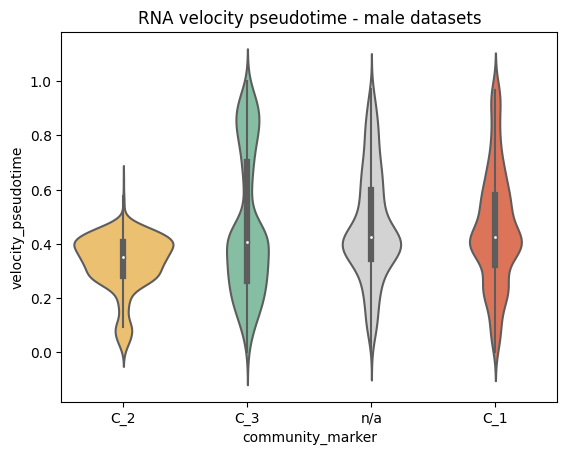

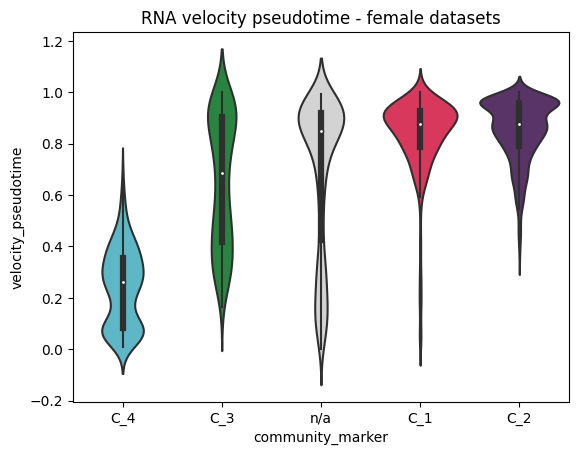

In [85]:
pseudotimes_M = pd.DataFrame()
pseudotimes_F = pd.DataFrame()

for dataset, adata in vel_objects.items():
        if dataset.endswith("M"):
            pseudotimes_M = pd.concat([pseudotimes_M, adata.obs[['community_marker', 'velocity_pseudotime']]])
        else:
            pseudotimes_F = pd.concat([pseudotimes_F, adata.obs[['community_marker', 'velocity_pseudotime']]])

comm_order = list(pseudotimes_M.groupby('community_marker').median().sort_values(by='velocity_pseudotime').index)
pseudotimes_M['community_marker'] = pd.Categorical(pseudotimes_M['community_marker'], categories=comm_order, ordered=True)

comm_order = list(pseudotimes_F.groupby('community_marker').median().sort_values(by='velocity_pseudotime').index)
pseudotimes_F['community_marker'] = pd.Categorical(pseudotimes_F['community_marker'], categories=comm_order, ordered=True)

community_palette = {"C_1": "#F16745",
                        "C_2": "#FFC65D", "C_3": "#7BC8A4", "n/a": "#D3D3D3"}

sns.violinplot(x='community_marker', y='velocity_pseudotime', data=pseudotimes_M, palette=community_palette)
plt.title("RNA velocity pseudotime - male datasets")

plt.show()

community_palette = {"C_1": "#F11E4E", "C_2": "#5B2C6F",
                        "C_3": "#1A9337", "C_4": "#4CC3D9", "n/a": "#D3D3D3"}

sns.violinplot(x='community_marker', y='velocity_pseudotime', data=pseudotimes_F, palette=community_palette)
plt.title("RNA velocity pseudotime - female datasets")

plt.show()